## Post-Processed Stitching
This notebook stitches measurements AFTER reconstruction is performed for each segment.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
from libwallerlab.utilities.io import Dataset, isDataset

# Platform imports
import os, glob
from os.path import expanduser
import numpy as np

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt

yp.config.setDefaultBackend('numpy')
yp.config.setDefaultDatatype('float32')

## Load Data

In [2]:
# Define user for path setting
dataset_path = expanduser("~") + '/datasets/motiondeblur/'
dataset_path = expanduser("~") + '/datasets/'

# Define output directory
output_path = os.path.join(dataset_path,'output')
output_path = '/home/sarah/deblurring/reconstructions'
output_path = '/home/ubuntu/reconstructions'

# Define which dataset to use
dataset_type = 'coded'
dataset_label = 'beads' # '174d' # '163c'
channel = 0


# Find files in this directory
saved_output_files = glob.glob(os.path.join(output_path, '*.npz'))
filtered_output_files = sorted([file for file in saved_output_files if dataset_label in file])

assert len([file for file in filtered_output_files if 'channel='+str(channel) in file]) > 0

print('Found %d files.'% len(filtered_output_files))
num_files = len(filtered_output_files)
segment_data = [None]*num_files
roi_list = [None]*num_files
measurement_list = [None]*num_files
recon_list = [None]*num_files
segment_index_list = [None]*num_files
for output_file in filtered_output_files:
    index = int(output_file.split('=')[1].split('.')[0].split('_')[0])
    print(output_file, index)
    segment_data = np.load(output_file)
    roi_list[index] = yp.Roi(**segment_data['roi'].item())
    measurement_list[index] = segment_data['y']
    recon_list[index] = segment_data['object_recovered']
    segment_index_list[index] = segment_data['segment_index']

# Move all ROI objects to origin
full_roi = sum(roi_list)
for roi in roi_list:
    roi -= full_roi.start
    roi.input_shape = full_roi.shape

Found 18 files.
/home/ubuntu/reconstructions/beads2_raster_45ms_coded_raster_100_motion_deblur_2019_02_04_16_34_43_strip=0_channel=0_subset=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17].npz 0
/home/ubuntu/reconstructions/beads2_raster_45ms_coded_raster_100_motion_deblur_2019_02_04_16_34_43_strip=10_channel=0_subset=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17].npz 10
/home/ubuntu/reconstructions/beads2_raster_45ms_coded_raster_100_motion_deblur_2019_02_04_16_34_43_strip=11_channel=0_subset=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17].npz 11
/home/ubuntu/reconstructions/beads2_raster_45ms_coded_raster_100_motion_deblur_2019_02_04_16_34_43_strip=12_channel=0_subset=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17].npz 12
/home/ubuntu/reconstructions/beads2_raster_45ms_coded_raster_100_motion_deblur_2019_02_04_16_34_43_strip=13_channel=0_subset=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17].npz 13
/home/ubunt

## Apply Segment Offsets To Correct Mis-Alignment

In [17]:
# segment_offset_x = -235
# segment_offset_y = -25

# for roi, segment_index in zip(roi_list, segment_index_list):
#     if not segment_index % 2 == 0: # put a not for brain!
#         roi -= (0, segment_offset_x)
#     else:
#         roi += (0, segment_offset_x)
        
#     roi += (segment_index * segment_offset_y, 0)
    
# # Move all ROI objects to origin
# full_roi = sum(roi_list)
# for roi in roi_list:
#     roi -= full_roi.start
#     roi.input_shape = full_roi.shape

## Normalize Frames

In [18]:
# scale_values, normalization_parameters = md.recon.normalize_roi_list(recon_list,
#                                                             roi_list, wrap_final_value=True)
# for i,frame in enumerate(recon_list):
#     frame *= scale_values[i]


## Register Frames

In [15]:
# shift_list = md.recon.register_roi_list(recon_list, roi_list,tolerance=(600,1000))
# for roi, shift in zip(roi_list, shift_list):
#     print(roi, shift)
#     roi += shift
#     # TODO changes to plus
# # takes 2 min

In [20]:
shift_list

## Perform Stitching

In [3]:
import ndoperators as ops

# Generate segmenetation Operator
G = ops.Segmentation(roi_list, full_roi.shape, alpha_blend_size=0) #1000)

# Concatenate measurements
y = ops.VecStack(recon_list)

# Perform reconstruction
stitched = G.inv * y

# takes 4 min

<IPython.core.display.Javascript object>


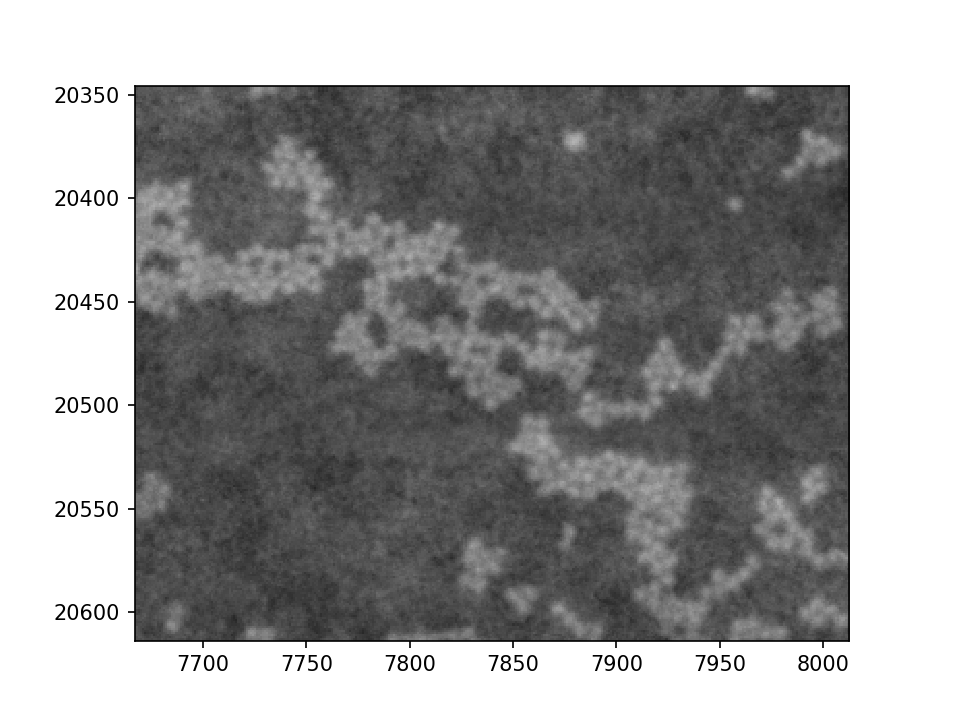

In [4]:
plt.figure()
plt.imshow(stitched, cmap='gray')
# plt.clim([0.7,1.5])

## Save Reconstruction

In [5]:
import tifffile
stitched_16 = stitched.copy()
stitched_16 -= np.min(stitched_16)
stitched_16 /= 0.99 *np.max(stitched_16)
# note that we changed to 8 bits
stitched_16 *= 255
stitched_16 = stitched_16.astype(np.uint8)


tifffile.imsave(os.path.join(output_path + '/stitched_recon_'+dataset_type+dataset_label+'channel='+str(channel)+'.tiff'), stitched_16)

In [6]:
output_path + '/stitched_recon_'+dataset_type+dataset_label+'channel='+str(channel)+'.tiff'

'/home/ubuntu/reconstructions/stitched_recon_codedbeadschannel=0.tiff'

In [6]:
# aws s3 mv ~/reconstructions/stitched_recon_coded_beads10_channel=0.tiff s3://motiondeblur/reconstructions/ --region us-east-2

'163c'